### Inference and Validation

In [7]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [8]:
# Define a transform to normalize the data
transform = transforms.Compose(
	[transforms.ToTensor(),
	 transforms.Normalize((0.5,), (0.5,))]
	)

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [9]:
class Classifier(nn.Module):
	def __init__(self):
		super().__init__()
		self.fc1 = nn.Linear(784, 256)
		self.fc2 = nn.Linear(256, 128)
		self.fc3 = nn.Linear(128, 64)
		self.fc4 = nn.Linear(64, 10)

	def forward(self, x):
		# make sure input tensor is flattened
		x = x.view(x.shape[0], -1)

		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = F.relu(self.fc3(x))
		x = F.log_softmax(self.fc4(x), dim=1)

		return x

In [10]:
model = Classifier()

images, labels = next(iter(testloader))

# get the class probabilities
ps = torch.exp(model(images))

# make sure the shape is appropriate
print(ps.shape)

torch.Size([64, 10])


In [11]:
top_p, top_class = ps.topk(1, dim=1)

# look at the most likely classes for the first 10 examples
print(top_class[:10, :])

tensor([[5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5]])


In [13]:
equals = top_class == labels.view(*top_class.shape)

accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item() * 100}%')

Accuracy: 7.8125%


#### training

In [16]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    tot_test_loss = 0
    test_correct = 0    # Number of correct predictions on the test set
    
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for images, labels in testloader:
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            tot_test_loss += loss.item()
    
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_correct += equals.sum().item()
    
    # Get mean loss to enable comparision between train and test sets
    train_loss = tot_train_loss / len(trainloader.dataset)
    test_loss = tot_test_loss / len(testloader.dataset)
    
    # At completion of epoch
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Epoch: {e + 1}/{epochs}..")
    print(f"Training Loss: {train_loss:.3f}")
    print(f"Test Loss: {test_loss:.3f}")
    print(f"Test Accuracy: {test_correct / len(testloader.dataset):.3f}")

Epoch: 1/30..
Training Loss: 0.519
Test Loss: 0.461
Test Accuracy: 0.828
Epoch: 2/30..
Training Loss: 0.394
Test Loss: 0.412
Test Accuracy: 0.850
Epoch: 3/30..
Training Loss: 0.358
Test Loss: 0.437
Test Accuracy: 0.855
Epoch: 4/30..
Training Loss: 0.337
Test Loss: 0.370
Test Accuracy: 0.867
Epoch: 5/30..
Training Loss: 0.313
Test Loss: 0.380
Test Accuracy: 0.862
Epoch: 6/30..
Training Loss: 0.301
Test Loss: 0.392
Test Accuracy: 0.861
Epoch: 7/30..
Training Loss: 0.297
Test Loss: 0.389
Test Accuracy: 0.870
Epoch: 8/30..
Training Loss: 0.286
Test Loss: 0.368
Test Accuracy: 0.867
Epoch: 9/30..
Training Loss: 0.274
Test Loss: 0.388
Test Accuracy: 0.863
Epoch: 10/30..
Training Loss: 0.270
Test Loss: 0.382
Test Accuracy: 0.872
Epoch: 11/30..
Training Loss: 0.259
Test Loss: 0.380
Test Accuracy: 0.872
Epoch: 12/30..
Training Loss: 0.253
Test Loss: 0.389
Test Accuracy: 0.875
Epoch: 13/30..
Training Loss: 0.250
Test Loss: 0.379
Test Accuracy: 0.875
Epoch: 14/30..
Training Loss: 0.243
Test Loss: 

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

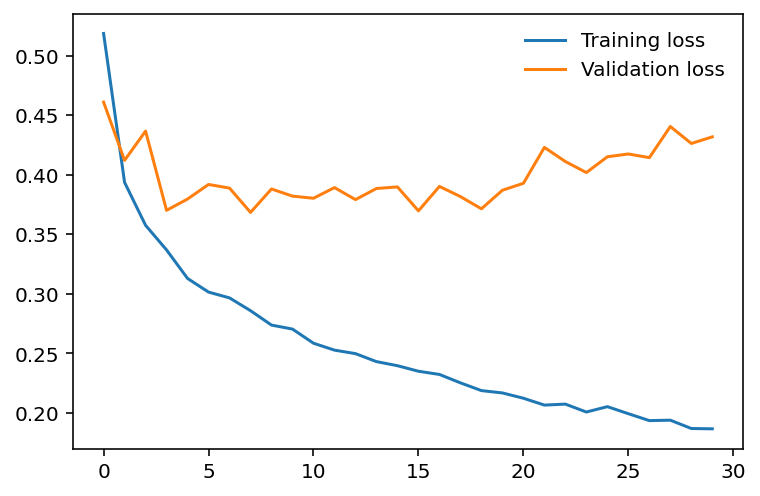

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

#### Overfitting

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

#### Add dropout to model

In [24]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout model with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        # add dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output (no dropout)
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [26]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        model.train()
        
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
        
        print(f"Epoch: {e + 1}/{epochs}..")
        print(f"Training Loss: {train_losses[-1]:.3f}")
        print(f"Test Loss: {test_losses[-1]:.3f}")
        print(f"Test Accuracy: {accuracy / len(testloader):.3f}")

Epoch: 1/30..
Training Loss: 38.777
Test Loss: 29.678
Test Accuracy: 0.827
Epoch: 2/30..
Training Loss: 30.963
Test Loss: 28.226
Test Accuracy: 0.838
Epoch: 3/30..
Training Loss: 29.076
Test Loss: 28.520
Test Accuracy: 0.844
Epoch: 4/30..
Training Loss: 27.796
Test Loss: 27.063
Test Accuracy: 0.851
Epoch: 5/30..
Training Loss: 27.116
Test Loss: 27.027
Test Accuracy: 0.852
Epoch: 6/30..
Training Loss: 26.164
Test Loss: 25.431
Test Accuracy: 0.859
Epoch: 7/30..
Training Loss: 25.727
Test Loss: 26.627
Test Accuracy: 0.857
Epoch: 8/30..
Training Loss: 25.096
Test Loss: 25.590
Test Accuracy: 0.859
Epoch: 9/30..
Training Loss: 25.111
Test Loss: 23.608
Test Accuracy: 0.868
Epoch: 10/30..
Training Loss: 24.958
Test Loss: 25.724
Test Accuracy: 0.859
Epoch: 11/30..
Training Loss: 24.559
Test Loss: 24.596
Test Accuracy: 0.865
Epoch: 12/30..
Training Loss: 24.475
Test Loss: 24.371
Test Accuracy: 0.866
Epoch: 13/30..
Training Loss: 24.027
Test Loss: 25.568
Test Accuracy: 0.862
Epoch: 14/30..
Traini

In [27]:
%matplitlib inline
%config InlineBackend.figure_format='retina'

UsageError: Line magic function `%matplitlib` not found.


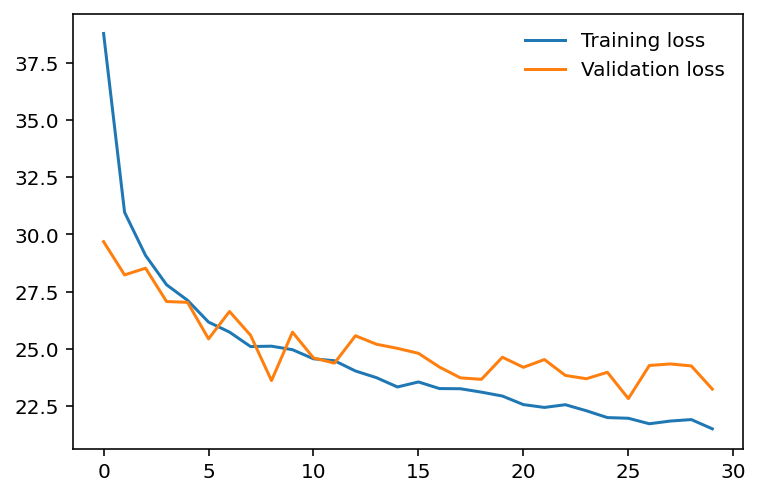

In [28]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

In [29]:
import helper

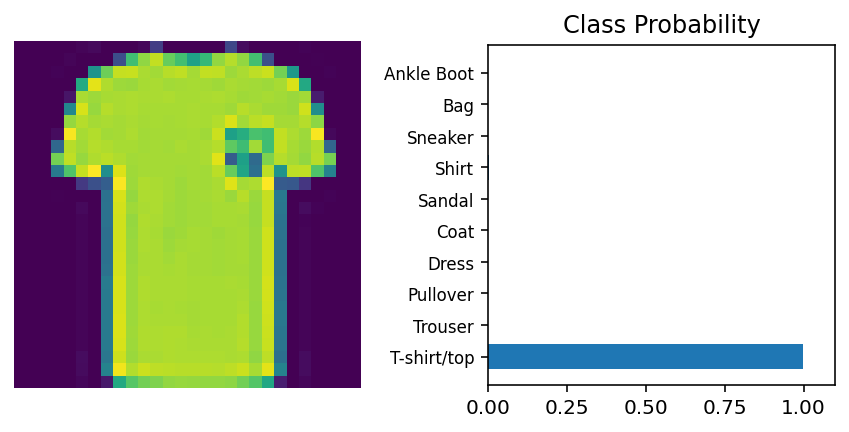

In [31]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

img = img.view(1, 784)

with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')